# Plot lattice

In [17]:
import os
import numpy as np
from specvae.model import BaseModel
import specvae.dataset as dt
import specvae.utils as utils

In [18]:
# Parameters
model_dirs = [
    "D:\\Workspace\\SpecVAE\\.model\\MoNA\\jointvae\\jointvae_20-800-200-50-3-50-200-800-20_01 (11-01-2022_23-10-10)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-800-200-50-3-50-200-800-20_01 (24-12-2021_01-50-12)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-400-100-3-400-20_02 (24-12-2021_03-34-34)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-1600-3-1600-20_03 (24-12-2021_00-17-31)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-800-3-800-20_04 (24-12-2021_00-25-10)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_20-100-3-90-100-20_05 (24-12-2021_03-01-19)",
    # "d:\\Workspace\\SpecVAE\\.model\\MoNA\\betavae_capacity_nextron\\betavae_capacity_50-400-3-100-400-50_06 (24-12-2021_06-19-49)"
]


In [19]:
plt.rcParams['svg.fonttype'] = 'none'

In [20]:
def load_model(path):
    device, cpu = utils.device(use_cuda=False)
    model_path = os.path.join(path, 'model.pth')
    model = BaseModel.load(model_path, device)
    model.eval()
    return model

In [21]:
import torch
import itertools as it

def lattice(model, grid=8, zrange=(-3, 3), dim1=0, dim2=1, rdim_value=0.):
    with torch.no_grad():
        latent_spec = model.config['latent_spec']
        cont_dim = latent_spec['cont']
        disc_dims = latent_spec['disc']
        dv = np.array(list(it.product(*[list(range(d)) for d in disc_dims])))
        dv_ohe = np.hstack([np.eye(d)[dv[:,i]] for i, d in enumerate(disc_dims)])
        if cont_dim == 1:
            z_ = np.linspace(zrange[0], zrange[1], grid, dtype=np.float32).reshape(-1, 1)
            z = torch.from_numpy(np.hstack((
                np.tile(z_, (dv_ohe.shape[0], 1)),
                np.repeat(dv_ohe, z_.shape[0], axis=0)
            )))
        elif cont_dim == 2:
            z = torch.zeros(1, 2)
            z = z.repeat(grid[0] * grid[1], 1)
            x = torch.linspace(zrange[0], zrange[1], grid[0])
            y = torch.linspace(zrange[0], zrange[1], grid[1])
            x_grid, y_grid = torch.meshgrid(x, y)
            z[:, 0] = x_grid.flatten()
            z[:, 1] = y_grid.flatten()
            # TODO ...
        elif cont_dim > 2:
            ...
        z = z.to(torch.float32).to(model.device)
        spectra = model.decode(z)
        spectra_ = spectra.reshape(dv_ohe.shape[0], grid, spectra.shape[1])
        z_ = z.reshape(dv_ohe.shape[0], grid, z.shape[1])
        return dv, dv_ohe, z_, spectra_


In [22]:
import specvae.visualize as vis
import torchvision as tv
import itertools as it

resolution = 0.5
max_mz=2500.
grid = 8
zrange = (-20., 20.)

Device in use:  cpu
D:\Workspace\SpecVAE\.model\MoNA\jointvae\jointvae_20-800-200-50-3-50-200-800-20_01 (11-01-2022_23-10-10)
[0 0]


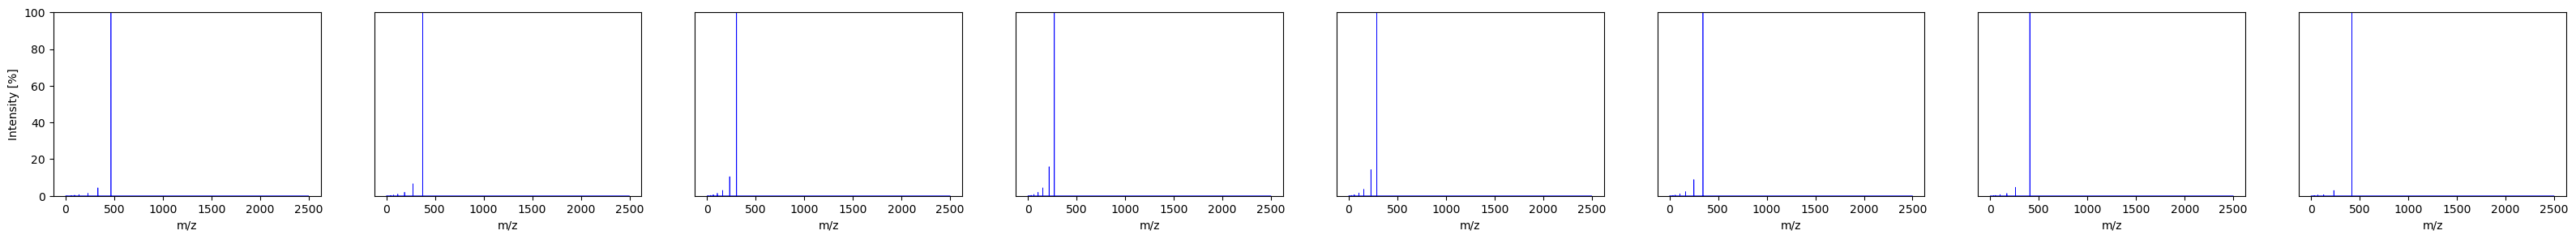

[0 1]


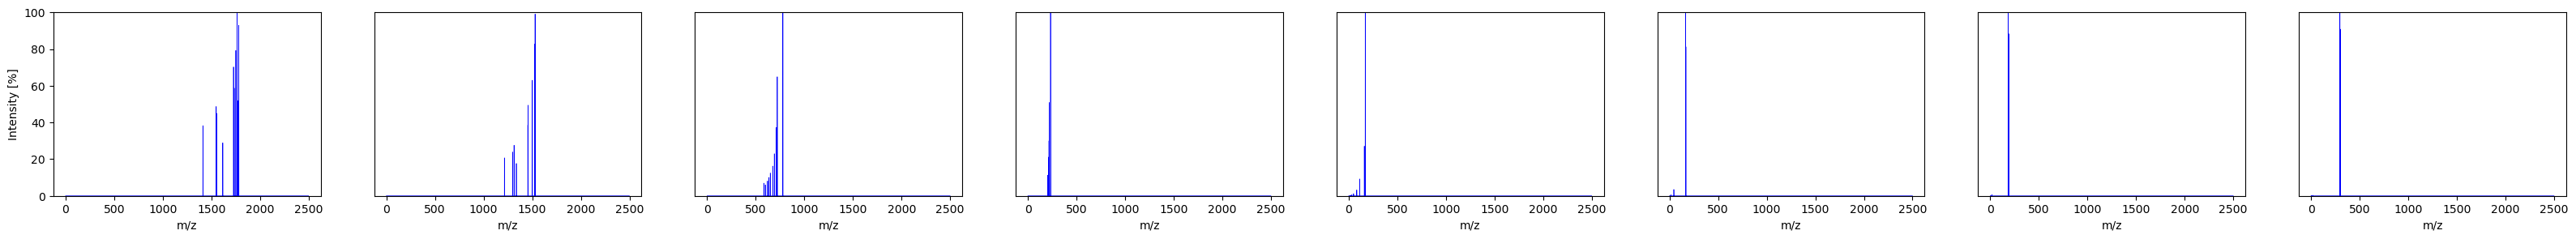

[0 2]


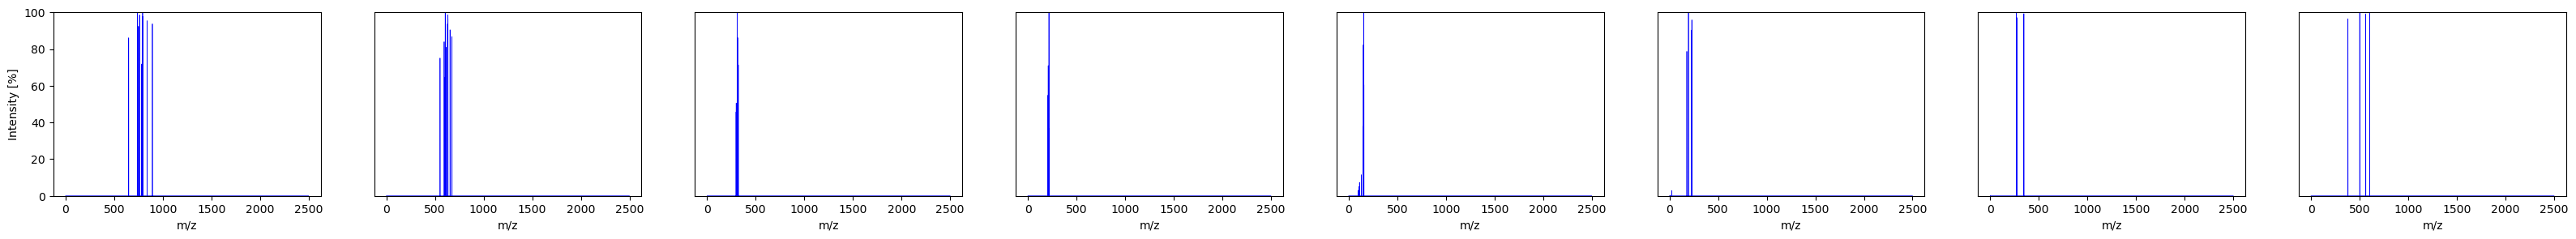

[0 3]


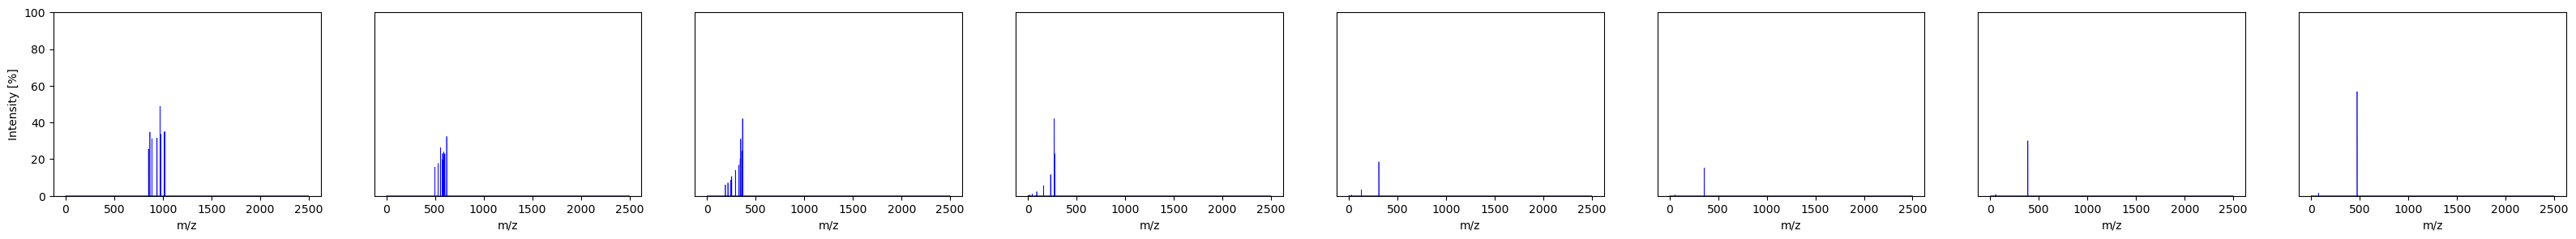

[0 4]


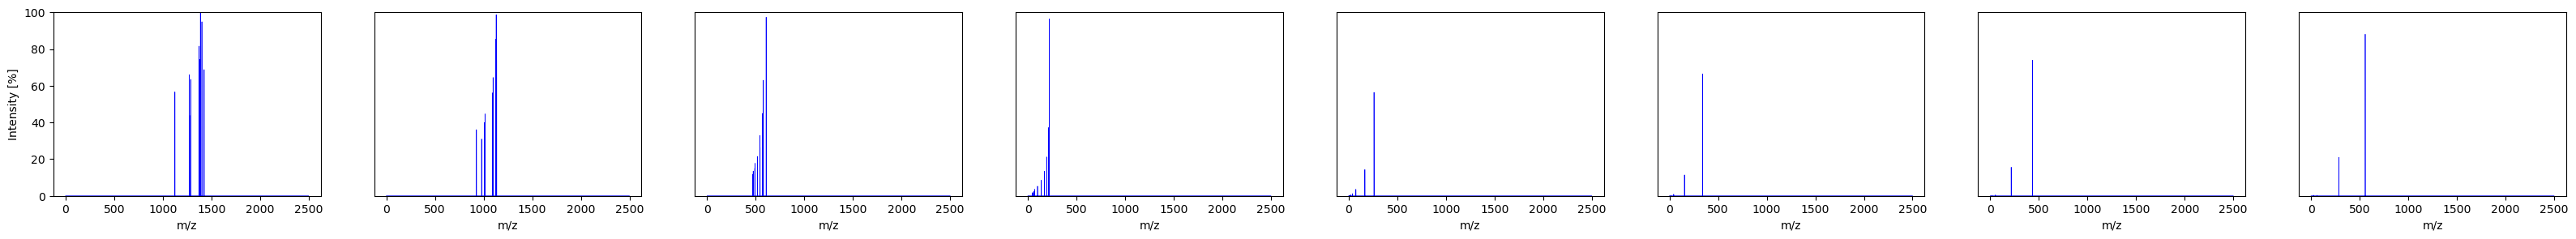

[0 5]


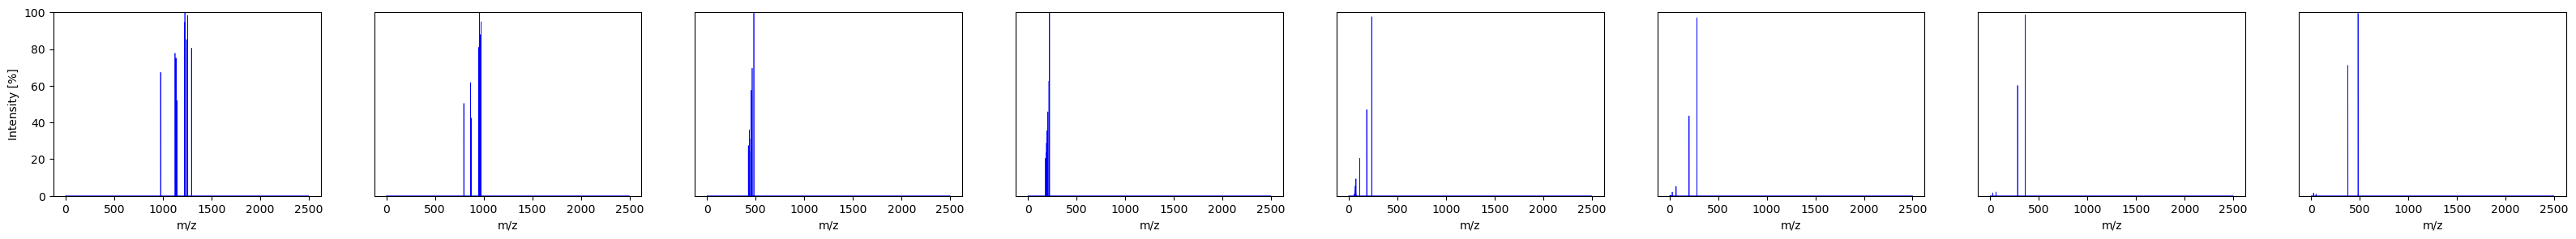

[1 0]


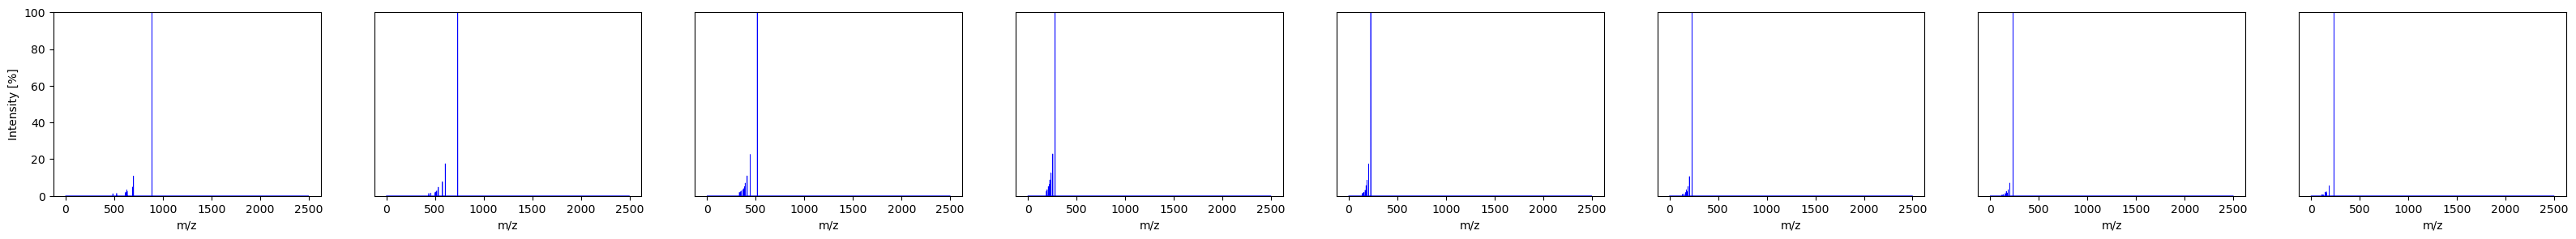

[1 1]


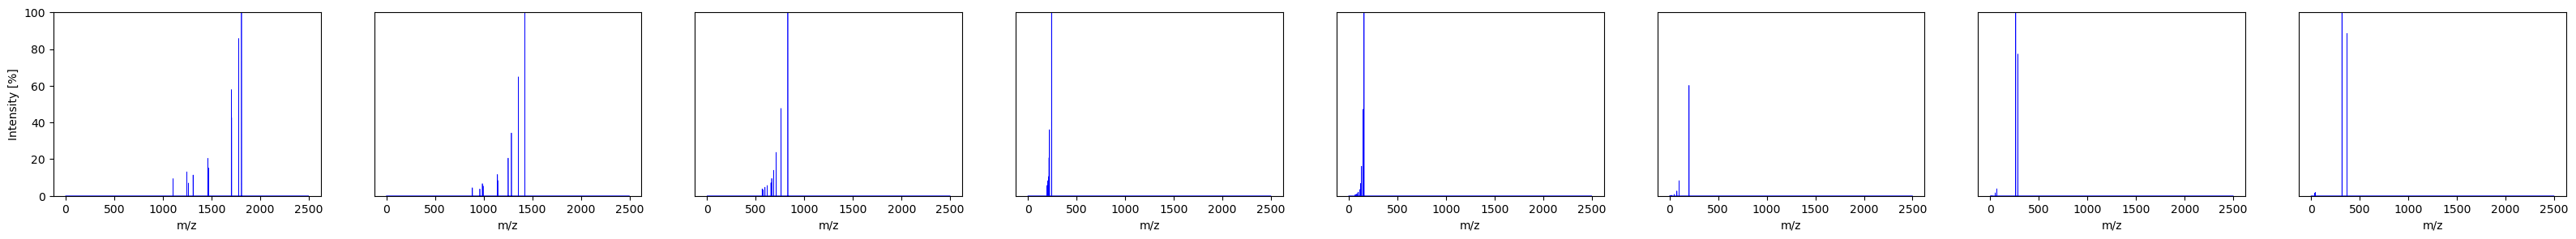

[1 2]


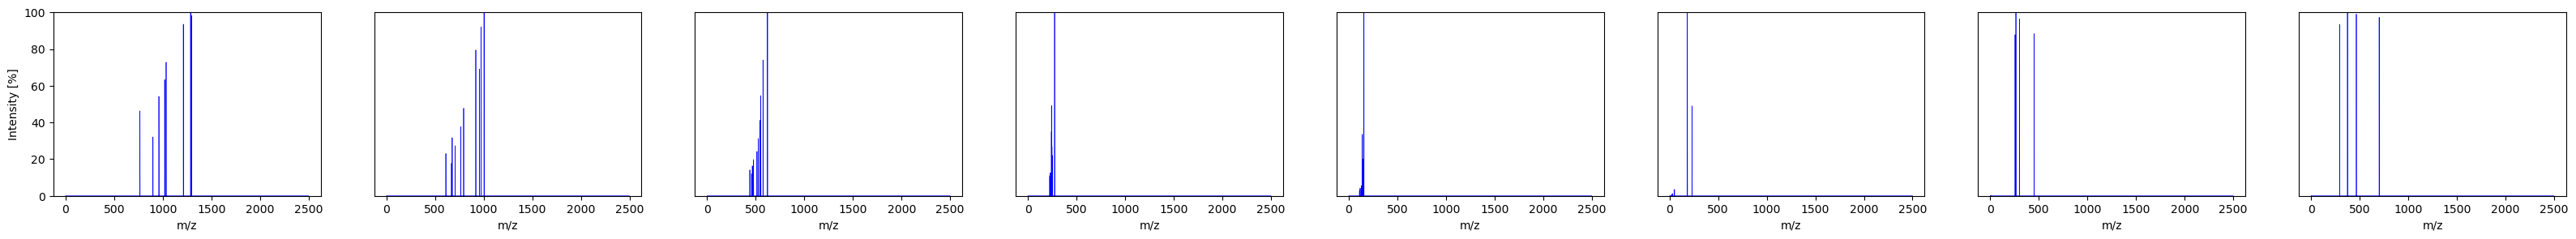

[1 3]


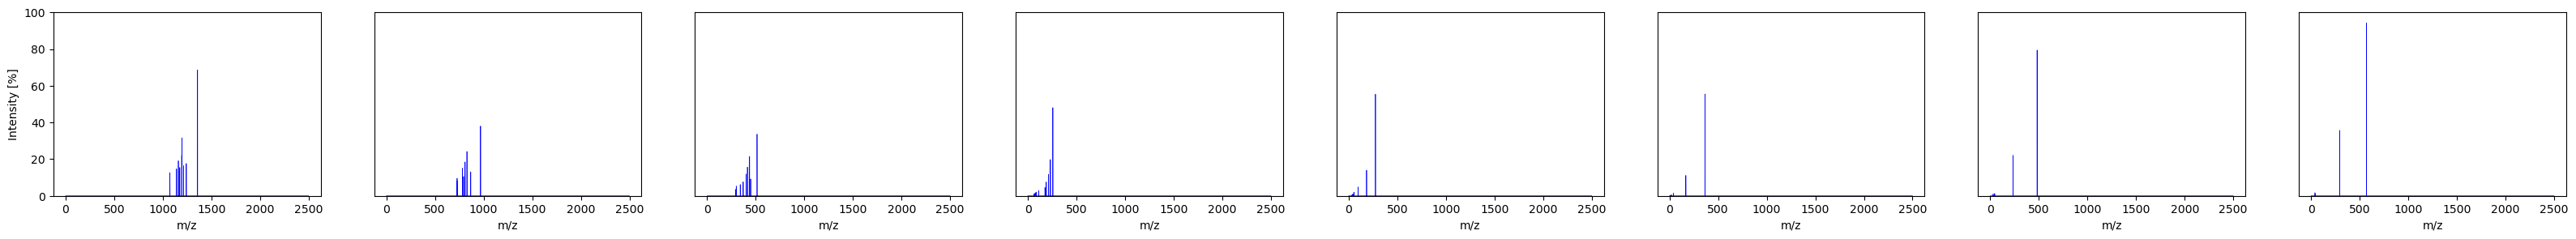

[1 4]


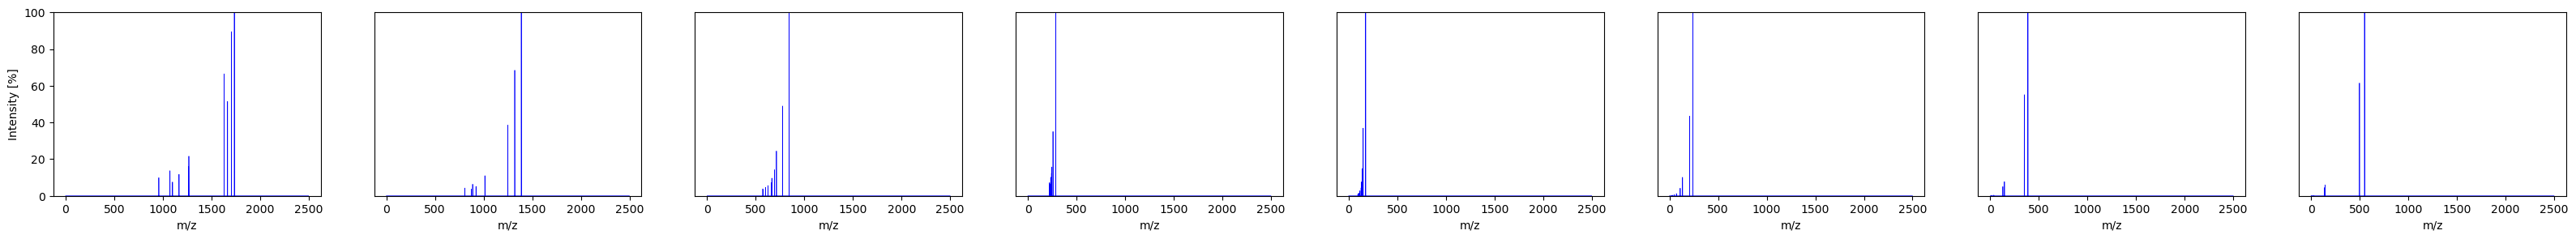

[1 5]


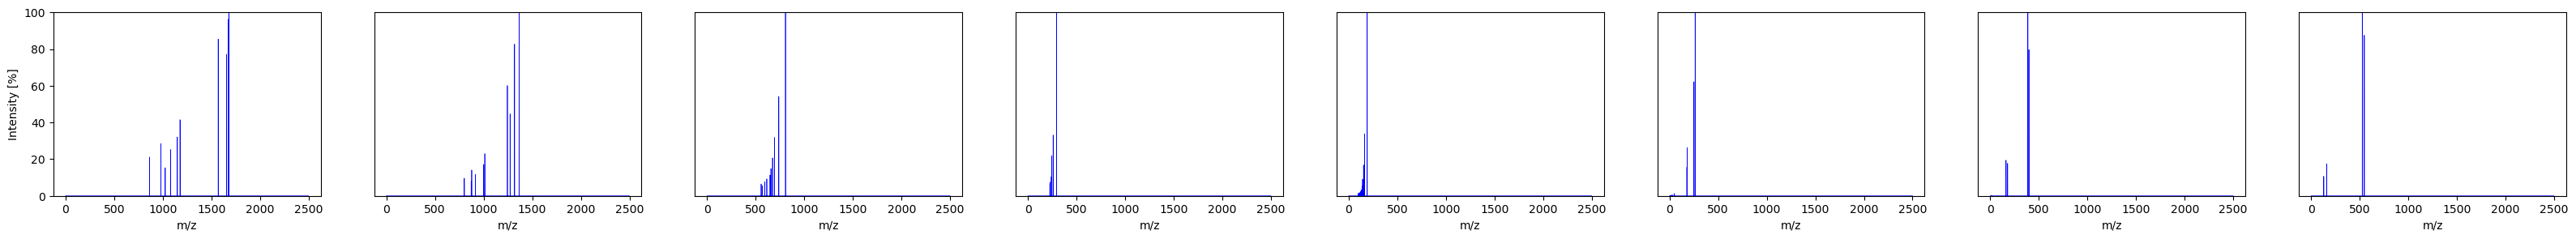

In [23]:
from IPython.display import display

for model_path in model_dirs:
    model = load_model(model_path)
    revtrans = tv.transforms.Compose([
        dt.ToMZIntDeConcatAlt(max_num_peaks=model.config['max_num_peaks']),
        dt.Denormalize(
            intensity=model.config['normalize_intensity'], 
            mass=model.config['normalize_mass'], max_mz=model.config['max_mz']),
        dt.ToDenseSpectrum(resolution=resolution, max_mz=model.config['max_mz'])
    ])

    print(model_path)
    disc_vals, disc_vals_ohe, z, spectra = lattice(model, grid=grid, zrange=zrange)
    for i, vals in enumerate(disc_vals):
        print(vals)
        # display(z_[i])
        vis.plot_spectra_(spectra[i], grid=(1, grid), figsize=(5*grid, 3), 
            resolution=resolution, max_mz=model.config['max_mz'], transform=revtrans)

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import matplotlib.ticker as tck
from matplotlib.lines import Line2D
from itertools import cycle, product
import itertools as it
import seaborn as sns
from functools import reduce

def discrete_plot(X, ys, transform, index_prefix='Var ',
        sunith=1.0, unith=1.0, unitv=1.0, scale=1.0, border=2.0, legend_offset=1.0, dpi=100):
    # Extract labels:
    labels = {i: list(range(1, y.shape[1] + 1)) for i, y in enumerate(ys)}
    height = np.prod([len(l) for k, l in labels.items()])
    # Specify GridSpec:
    widths = np.array([sunith] * len(labels) + [unith] * X.shape[1])
    heights = np.array([unitv] * height + [legend_offset*unitv])
    gs_kw = dict(width_ratios=widths, height_ratios=heights)
    fig, axs = plt.subplots(
        ncols=len(widths), nrows=len(heights), subplot_kw=dict(frameon=True),
        constrained_layout=False, gridspec_kw=gs_kw, 
        figsize=(scale * widths.sum(), scale * heights.sum()), dpi=dpi)
    # Define color mappings:
    from matplotlib.cm import get_cmap
    cmaps = cycle(['Purples', 'Reds', 'Blues', 'Oranges', 'Greens', ])
    def map_disc_(items, cmap_name):
        cmap_ = get_cmap(cmap_name)
        inter_ = 0.3
        slope_ = (1. - inter_) / len(items)
        return {value: cmap_(inter_ + items.index(value) * slope_) for value in items}
    colors = {label: map_disc_(items, cmap_name) \
        for (label, items), cmap_name in zip(labels.items(), cmaps)}
    labels_ = list(product(*list(labels.values())))
    for r, row in enumerate(axs):
        for c, ax in enumerate(row):
            for _, spine in ax.spines.items():
                spine.set_visible(False)
            if r == len(axs) - 1:
                ax.set(xticks=[], yticks=[])
                ax.patch.set_alpha(0.)
                continue
            if c < len(labels):
                ax.set(xticks=[], yticks=[])
                var_name = c
                var_value = labels_[r][c]
                ax.add_patch(pch.Rectangle((0., 0.), unith, unitv, 
                    facecolor=colors[var_name][var_value], edgecolor='black', label=var_value, zorder=500))
                for _, spine in ax.spines.items():
                    spine.set_linewidth(border)
            else:
                ax.set(yticks=[], xticks=[])
                for _, spine in ax.spines.items():
                    spine.set_visible(True)
                    spine.set_linewidth(0.5)
                var_value = labels_[r]
                spectrum = X[r][c - len(labels)]
                if transform:
                    import torch
                    if torch.is_tensor(spectrum):
                        spectrum = transform(spectrum.detach().numpy())
                    else:
                        spectrum = transform(spectrum)
                mz = np.arange(0, max_mz, step=resolution)
                ax.plot(mz, spectrum.tolist(), color='blue', linewidth=0.5)
                ax.set_ylim([0, 100])
                grid = (X.shape[0], X.shape[1])
                if grid[0] - 1 == r:
                    ax.set_xticks([500, 1500, 2500])
                    ax.set_xlabel('m/z')
                handles, lbs = ax.get_legend_handles_labels()

    # Build the legend:
    sizes = [len(ll) for ln, ll in labels.items()]
    largest_label_inx = np.argmax(sizes)
    ## Categorical variables:
    hndl = []
    for i, (lbl, colors_) in enumerate(colors.items()):
        size, empty = len(colors_), []
        if i >= 1:
            m = sizes[largest_label_inx] - sizes[i - 1]
            if m > 0:
                empty = [Line2D([], [], label='', alpha=0.)] * m
        hndl += empty + [Line2D([], [], label=index_prefix + str(lbl + 1), alpha=0.)] + [
            pch.Patch(facecolor=color, edgecolor="k", label=label, alpha=0.7) 
            for label, color in colors_.items()
        ]

    legend = fig.legend(handles=hndl, loc='lower center', handlelength=scale*1.4, handleheight=scale*1.6, ncol=len(labels), labelspacing=.0)
    legend.get_frame().set_alpha(0.)
    plt.subplots_adjust(hspace=0, wspace=0.)
    return fig

Device in use:  cpu
D:\Workspace\SpecVAE\.model\MoNA\jointvae\jointvae_20-800-200-50-3-50-200-800-20_01 (11-01-2022_23-10-10)


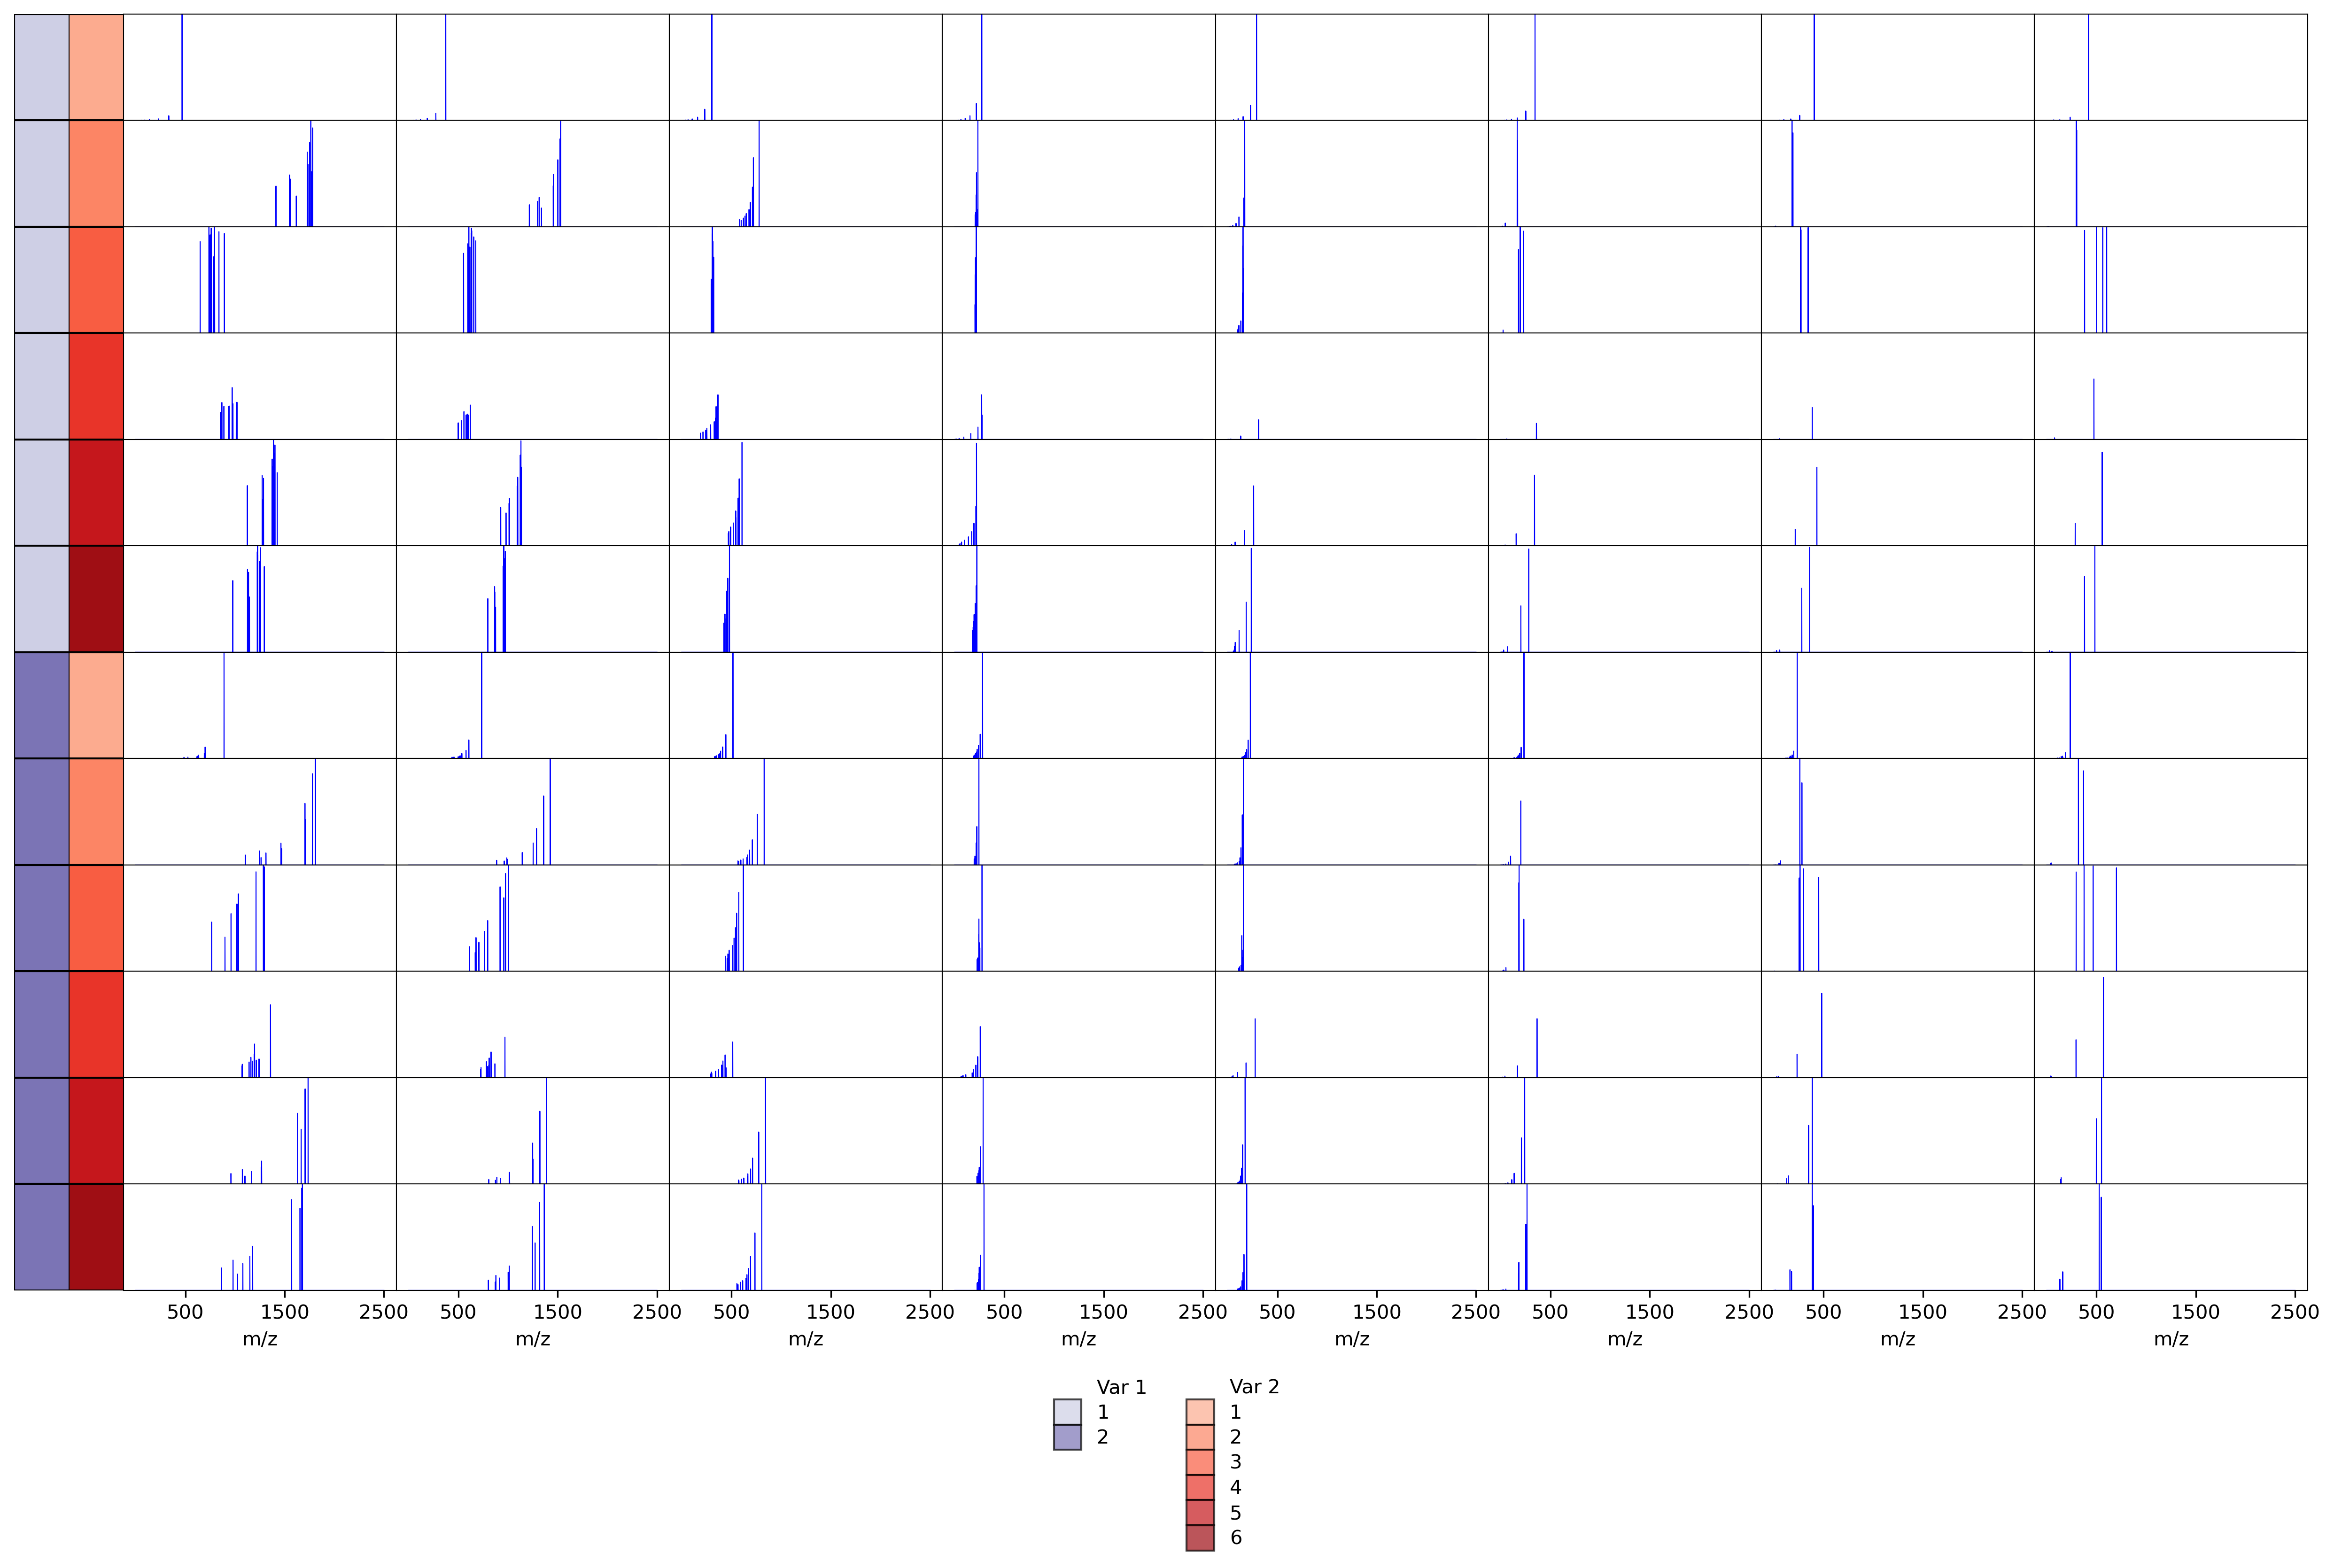

In [25]:
for model_path in model_dirs:
    model = load_model(model_path)
    revtrans = tv.transforms.Compose([
        dt.ToMZIntDeConcatAlt(max_num_peaks=model.config['max_num_peaks']),
        dt.Denormalize(
            intensity=model.config['normalize_intensity'], 
            mass=model.config['normalize_mass'], max_mz=model.config['max_mz']),
        dt.ToDenseSpectrum(resolution=resolution, max_mz=model.config['max_mz'])
    ])
    latent_spec = model.config['latent_spec']
    cont_dim = latent_spec['cont']
    disc_dims = latent_spec['disc']

    print(model_path)
    disc_vals, disc_vals_ohe, z, spectra = lattice(model, grid=grid, zrange=zrange)
    disc_Zs = [disc_vals_ohe[:,dim1:dim1 + dim2] for dim1, dim2 in zip([0] + disc_dims, disc_dims)]
    fig = discrete_plot(spectra, disc_Zs, revtrans, sunith=0.5, unith=2.5, scale=1., legend_offset=0.5, dpi=300)
    fig.savefig(f'../.img/lattice/jointvae-lattice.svg')
    fig.savefig(f'../.img/lattice/jointvae-lattice.png')
    plt.show()